# ML using scikit learn

## Predicting absenteeism
A large problem within organisations is how to motivate their employees. This is a continuation of the [previous blog]() where we went thru various feature engineering methods to come up with a comprehensive dataset. In this blog, we will use this data in order to predict employment absenteeism. The goal is to identify who are likely to be absent in the near future. This blog doesnt go thru the machine learning concepts, or business logic, but implementation of machiner learning using *scikit-learn* package in python. 

As a first step, let us load and look at the data.

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
%matplotlib inline 

In [3]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("data_after_feature_engg.csv")
df['date'] = pd.to_datetime(df.date)
df.head()

,employee,date,last_likes,last_dislikes,feedbackType,likes_till_date,dislikes_till_date,last_2_likes,last_2_dislikes,days_since_last_comment,last_vote,timezone,stillExists,no_of_days_since_first_vote,no_of_votes_till_date,perc_days_voted,avg_vote_till_date,avg_vote,last_2_votes_avg,days_since_last_vote,employee_joined_after_jun17,countdown_to_last_day,reason,on_leave,no_leaves_till_date,last_2_days_leaves,previous_day_leave,weekday,month,day,week
0,17r,2018-05-29,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,1,1,1.0,3.0,2.121212,3.0,0,1,999,NaN,0,0,0,0,Tuesday,May,29,1
1,17r,2018-05-30,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,1,1,1.0,3.0,2.121212,3.0,0,1,999,NaN,0,0,0,0,Wednesday,May,30,2
2,17r,2018-05-31,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,2,1,1.0,3.0,2.121212,3.0,1,1,999,NaN,0,0,0,0,Thursday,May,31,3
3,17r,2018-01-06,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,3,2,0.5,3.0,2.121212,3.0,0,1,999,NaN,0,0,0,0,Friday,Jun,1,1
4,17r,2018-02-06,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,4,2,0.5,3.0,2.121212,3.0,0,1,999,NaN,0,0,0,0,Saturday,Jun,2,2


This data is at a employee-day level and we can predict if any employee will take leave on any particular date. As very few employees take leave on any particular day, we will have a highly imbalanced dataset.

In [4]:
1-df.on_leave.mean()

0.9514513766404592

This indicates that only 5% of the dataset contains information about employees taking leaves. This means that if we predicted that all the employees are not taking a leave (class 0), we would be 95% accurate, but such prediction is not useful. This is the base model, and we need to see to it that we have accuracy greater than 95%.

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,plot_confusion_matrix, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

From the different features that we have created, we are selecting what we think will be relavent features for predicting which employee might be absent.

In [6]:
indep_vars = ['last_likes', 'last_dislikes', 'feedbackType', 
     'likes_till_date', 'dislikes_till_date', 'last_2_likes', 'last_2_dislikes', 
     'days_since_last_comment', 'last_vote', 'timezone', 'stillExists',
       'no_of_days_since_first_vote', 'no_of_votes_till_date',
       'perc_days_voted', 'avg_vote_till_date', 'avg_vote', 'last_2_votes_avg',
       'days_since_last_vote', 'employee_joined_after_jun17', 'countdown_to_last_day',
        'no_leaves_till_date', 'weekday', 'month']

The dependent variable is *on_leave*. We are also creating dummy variables that represent categorical data.

In [7]:
data_targets = df['on_leave'].astype('int')
data_features = pd.get_dummies(df[indep_vars], prefix = "_", drop_first= True)

To prevent overfitting, we are splitting the data into test data and train data. Test data has 30% of the data (selected randomly) while the train data has the remaining 70% on which we train the model. This model is tested against the test data to validate for overfitting.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data_features, data_targets, test_size=.30, random_state=35, \
                                                    stratify=data_targets)

Before building an ensemble of models, we can build a decision tree model and understand if the features we have selected perform the classification in a reasonable manner.

In [9]:
tree_clf = DecisionTreeClassifier(random_state=35, max_depth=3, class_weight="balanced").fit(x_train,y_train)

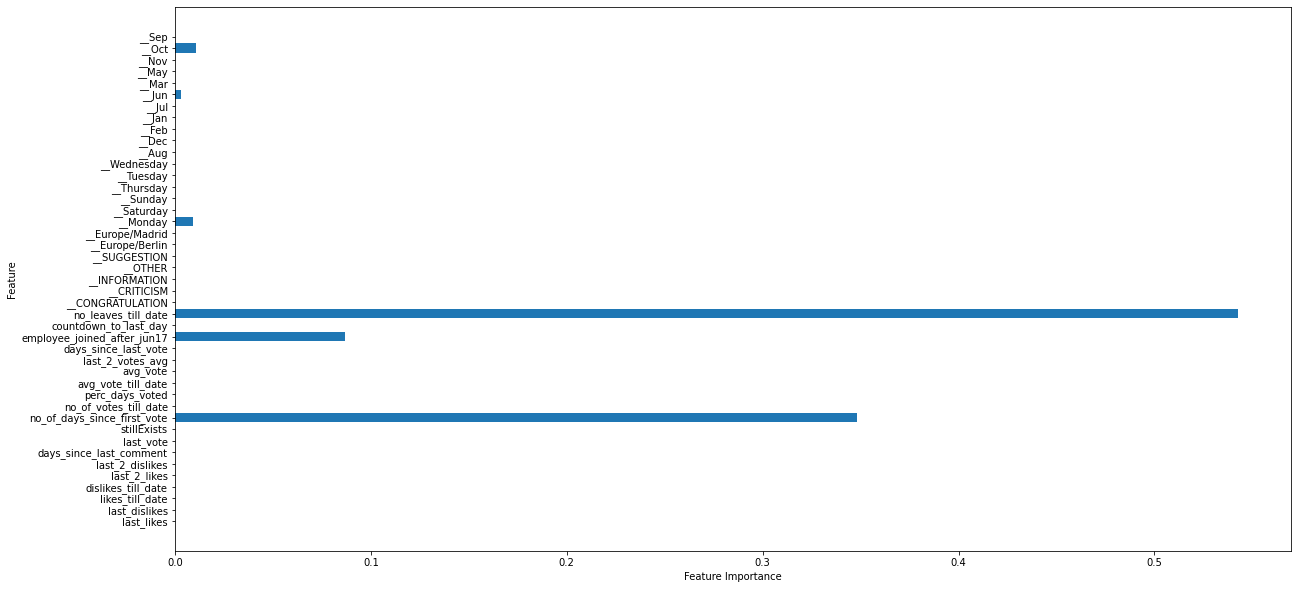

In [10]:
def plot_feature_importance(model):
    fs, ax = plt.subplots(1, figsize=(20,10))
    number_of_features = x_train.shape[1]
    plt.barh(range(number_of_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(number_of_features),x_train.columns)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
plot_feature_importance(tree_clf)

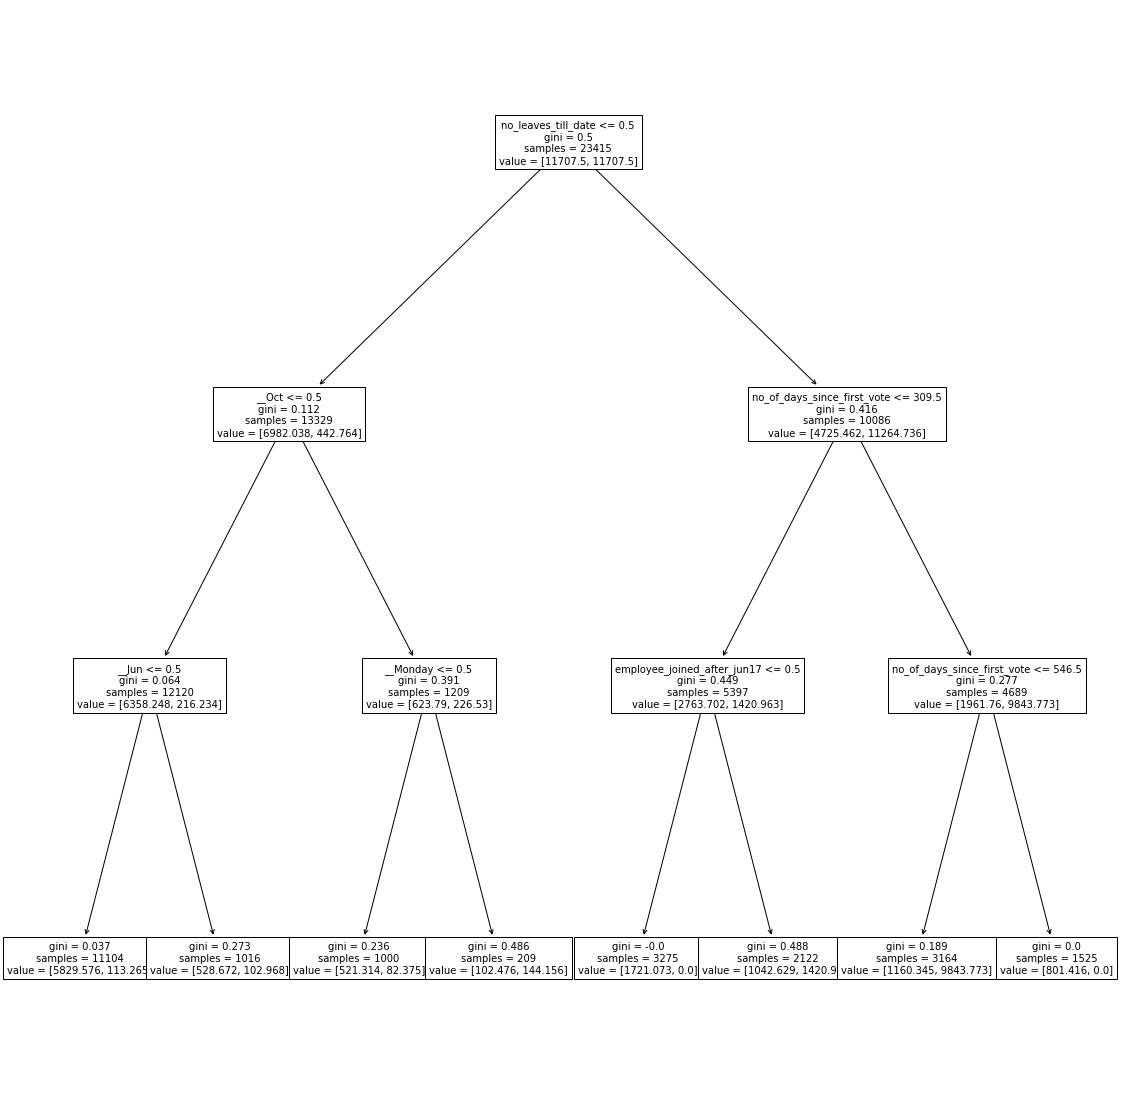

In [11]:
plt.figure(figsize=(20,20))
plot_tree(tree_clf,  fontsize=10, feature_names = x_train.columns)
plt.show()

We can observe that the features that are important make reasonable sense. 
1. *Number of leaves till date*: The number of leaves that an employee has taken already will effect the future leaves that a person would take
2. *number of days since forst vote* (proxy to the employee tenure), *employee_joined_after_Jun17* (proxy to newer employees) are significant and we have seen these trends in the visualisations in the [feature engineering section](https://www.harshaash.com/Python/Machine%20Learning%20Part%201/#feature-engineering)
3. As seen in the [visualisations](https://www.harshaash.com/Python/Machine%20Learning%20Part%201/#employee-absenteeism-dataset), employees took leaves during months like *June* and *October* which have come up as significant in the analysis

We can see the model is not overfit with similar accuracy across test and train datasets. The confusion matrix is plotted below:

Accuracy on train data is 0.81
Accuracy on test data is 0.81


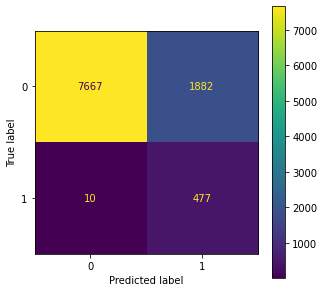

In [12]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(tree_clf, x_test, y_test)
print('Accuracy on train data is', round(tree_clf.score(x_train, y_train),2))
print('Accuracy on test data is', round(tree_clf.score(x_test, y_test),2))

In [13]:
y_test_pred = tree_clf.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      9549
           1       0.20      0.98      0.34       487

    accuracy                           0.81     10036
   macro avg       0.60      0.89      0.61     10036
weighted avg       0.96      0.81      0.86     10036



We can observe that the precision is just 20% (on classifying when an employee will take a leave). This is due to imbalance of classes. This can be rectified by many ways, one of which includes under-sampling. For other methods, [refer the blog on handling imbalanced classes](http://aharsha.com/handling-imbalanced-classes/). We are also using GridSearch to find the best tuning parameters and 5 fold cross validation.  

In [13]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
param_grid_dt = {
    'classification__criterion': ['gini', 'entropy'],
    'classification__max_depth': [2,5,10],
    'classification__max_features':[0.2, 0.5, 0.8]
}
model_dt_p = Pipeline([
    ('sampling', RandomUnderSampler()), # While training, downsample the majority class randomly
    ('classification', DecisionTreeClassifier()) # Train and predict using rf classification model
    ])
model_dt = GridSearchCV(model_dt_p, param_grid_dt, cv=5)
model_dt.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', RandomUnderSampler()),
                                       ('classification',
                                        DecisionTreeClassifier())]),
             param_grid={'classification__criterion': ['gini', 'entropy'],
                         'classification__max_depth': [2, 5, 10],
                         'classification__max_features': [0.2, 0.5, 0.8]})

In [1]:
y_test_pred = model_dt.predict(x_test)
print(classification_report(y_test, y_test_pred))
print('Accuracy on train data is', round(model_dt.score(x_train, y_train),2))
print('Accuracy on test data is', round(model_dt.score(x_test, y_test),2))

NameError: name 'model_dt' is not defined

Here we observe that with a simple decision tree classifier, we already reach an accuracy above 95% (base accuracy) with good precision and recall values. This model is better than our base model. We could further improve it by using ensemble methods which we will look into later in the blog.

Best params for the model {'classification__criterion': 'entropy', 'classification__max_depth': 10, 'classification__max_features': 0.5}
Best score on the cross validation data 0.96
Accuracy on train data 0.96
Accuracy on test data 0.96


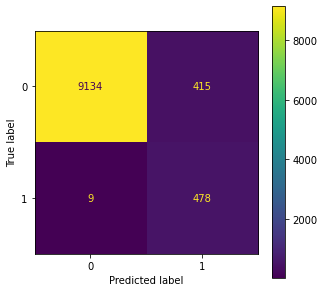

In [15]:
def print_stats(model):
    print('Best params for the model', model.best_params_)
    print('Best score on the cross validation data', round(model.best_score_, 2))
    print('Accuracy on train data', round(model.score(x_train, y_train),2))
    print('Accuracy on test data', round(model.score(x_test, y_test),2))
print_stats(model_dt)
plot_confusion_matrix(model_dt, x_test, y_test)
plt.show()

In [16]:
y_test_pred = model_dt.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9549
           1       0.54      0.98      0.69       487

    accuracy                           0.96     10036
   macro avg       0.77      0.97      0.84     10036
weighted avg       0.98      0.96      0.96     10036



After manually applying a few models, we can scale up to use grid search method to search for the best classifier and parameters in a quick and efficient manner. We can use Logistic Regression, Multinomial Naive Bayes, KNN Classifiers, Ensemble models and any model in the [sklearn library](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [18]:
# setting up models

clf1 = LogisticRegression(random_state=35)
clf2 = MultinomialNB()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier(random_state=35)
clf5 = RandomForestClassifier(random_state = 35)
clf6 = GradientBoostingClassifier(random_state = 35)

In [19]:
# setting up hyperparameters 

# Hyperparameters for Logistic regression https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
hyperparam1 = {}
hyperparam1['classifier__C'] = [10**-4, 10**-1, 10**0] # The hyper-parameter is C and its inside 'classifier' part of pipeline
hyperparam1['classifier__penalty'] = ['l1', 'l2'] # The hyper-parameter is penalty and its inside 'classifier' part of pipeline
hyperparam1['classifier__class_weight'] = [None, 'balanced']
hyperparam1['classifier'] = [clf1]

# Hyperparameters for Naive Bayes
hyperparam2 = {}
hyperparam2['classifier__alpha'] = [10**0,10**4]
hyperparam2['classifier'] = [clf2]

# Hyperparameters for KNN
hyperparam3 = {}
hyperparam3['classifier__n_neighbors'] = [2, 5, 10]
hyperparam3['classifier'] = [clf3]

# Hyperparameters for Decision Trees
hyperparam4 = {}
hyperparam4['classifier__max_depth'] = [2,5,10, None]
hyperparam4['classifier__min_samples_split'] = [2, 5, 10]
hyperparam4['classifier__class_weight'] = [None, 'balanced']
hyperparam4['classifier'] = [clf4]

# Hyperparameters for Random Forest
hyperparam5 = {}
hyperparam5['classifier__n_estimators'] = [100, 250]
hyperparam5['classifier__max_depth'] = [2,5,10]
hyperparam5['classifier__class_weight'] = [None, 'balanced']
hyperparam5['classifier'] = [clf5]

# Hyperparameters for Gradient Boosting
hyperparam6 = {}
hyperparam6['classifier__n_estimators'] = [100, 250]
hyperparam6['classifier__max_depth'] = [2, 5, 10]
hyperparam6['classifier__min_samples_split'] = [2, 5, 10]
hyperparam6['classifier'] = [clf6]

pipe = Pipeline([('classifier',clf1)])
hyperparam_total = [hyperparam1, hyperparam2, hyperparam3, hyperparam4, hyperparam5, hyperparam6]

In [41]:
%%time
# Record how long the search takes

# Train the grid search model
model_grid_search = GridSearchCV(pipe, hyperparam_total, cv=3, n_jobs=-1, scoring='roc_auc').fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.76530486        nan 0.78573417        nan 0.76227159
        nan 0.81272732        nan 0.7669747         nan 0.81235721
        nan        nan 0.9792672  0.98689225 0.98684304 0.80196935
 0.80196935 0.80196935 0.9807685  0.9807685  0.98227199 0.974107
 0.97684471 0.98018112 0.96721555 0.9697727  0.97256904 0.87247414
 0.87247414 0.87247414 0.95249357 0.95249357 0.95249357 0.96331177
 0.96410843 0.96467699 0.96485967 0.96883658 0.97032722 0.96982298
 0.96802826 0.99322296 0.99325364 0.99761825 0.99778465 0.96814859
 0.97048243 0.98832118 0.98900645 0.9941528  0.99483174 0.99417744
 0.99651075 0.99417744 0.99651075 0.99417744 0.99651075 0.99771714
 0.99782095 0.99764383 0.99792168 0.99770636 0.99797557 0.99532432
 0.99816234 0.99575252 0.99821671 0.99738392 0.99794075]
  warnings.warn(


Wall time: 22min 59s


In [42]:
# Output the best estimator which is a random forecast classifier 
model_grid_search.best_estimator_

Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(max_depth=10, min_samples_split=5,
                                            n_estimators=250,
                                            random_state=35))])

After running gridsearch to find the best parameters and models, we find the best model to be Gradient Boodting with the best parameters below.

In [43]:
# Output the parameters in the best estimator
model_grid_search.best_params_

{'classifier': GradientBoostingClassifier(max_depth=10, min_samples_split=5, n_estimators=250,
                            random_state=35),
 'classifier__max_depth': 10,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 250}

The accuracy on the cross validated data close to 99%.

In [44]:
round(model_grid_search.best_score_, 4)

0.9982

On the test data also, we have a near perfect precision, recall and accuracy.

In [45]:
y_test_pred = model_grid_search.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9549
           1       0.99      0.96      0.97       487

    accuracy                           1.00     10036
   macro avg       0.99      0.98      0.99     10036
weighted avg       1.00      1.00      1.00     10036



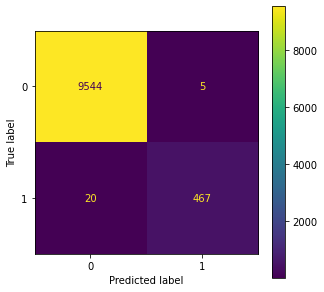

In [46]:
plot_confusion_matrix(model_grid_search, x_test, y_test)
plt.show()

The features that are used and their importances in the model is:

In [47]:
def print_most_imp_features(model, data_features):
    feat_imp_df = pd.DataFrame({'columns' : data_features.columns, 'importance':(model.best_estimator_.named_steps["classifier"].feature_importances_*100).astype(int)})
    return feat_imp_df[feat_imp_df.importance>0].sort_values('importance', ascending=False)
print_most_imp_features(model_grid_search, data_features)

,columns,importance
18,no_leaves_till_date,28
9,no_of_days_since_first_vote,25
32,__Aug,8
41,__Oct,7
37,__Jun,6
12,avg_vote_till_date,5
11,perc_days_voted,3
13,avg_vote,3
5,last_2_dislikes,2
3,dislikes_till_date,1


In [58]:
def plot_roc_curve(fpr, tpr, auc):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.grid()
    ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
            bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, 'k--')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.title('ROC curve')

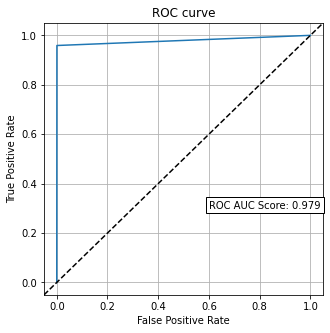

In [59]:
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr, tpr, auc)

## Predictions
Using this model, we can predict who is going to be absent in the next few days.

In [50]:
next_day_df = df[df.date == max(df.date)].reset_index()
next_day_df.no_of_days_since_first_vote += 1
next_day_df.days_since_last_vote += 1

day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
month_name = [None, 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
next_day_df.date = next_day_df.date + pd.DateOffset(1)
next_day_df['weekday'] = next_day_df.date.dt.weekday.apply(lambda x:day_name[x])
next_day_df['month'] = next_day_df.date.dt.month.apply(lambda x:month_name[x])
next_day_df['week'] = next_day_df.date.dt.day

# Handle catogorical variables
next_day_df_predict = pd.get_dummies(next_day_df[indep_vars], prefix = "_")
next_day_df_predict = next_day_df_predict.reindex(columns=x_train.columns, fill_value=0)

prob_current = model_grid_search.predict_proba(next_day_df_predict)
next_day_df['leave_prob'] = prob_current[:,1]

The top 5 employees who have the highest probability to be absent in the next day are:

In [51]:
next_day_df.sort_values('leave_prob', ascending = False).head(5)

,index,employee,date,last_likes,last_dislikes,feedbackType,likes_till_date,dislikes_till_date,last_2_likes,last_2_dislikes,days_since_last_comment,last_vote,timezone,stillExists,no_of_days_since_first_vote,no_of_votes_till_date,perc_days_voted,avg_vote_till_date,avg_vote,last_2_votes_avg,days_since_last_vote,employee_joined_after_jun17,countdown_to_last_day,reason,on_leave,no_leaves_till_date,last_2_days_leaves,previous_day_leave,weekday,month,day,week,leave_prob
22,13699,DNY,2019-12-03,0,0,0,0,0,0,0,0,3,Europe/Madrid,1,651,229,0.352851,2.934498,2.936441,3.0,1,0,999,NaN,0,2,0,0,Tuesday,Dec,12,3,9.382249e-10
34,20478,YDm,2019-12-03,19,0,CONGRATULATION,523,250,34,9,42,3,Europe/Madrid,1,651,537,0.827427,2.942272,2.943636,3.0,1,0,999,NaN,0,1,0,0,Tuesday,Dec,12,3,7.326212e-10
38,22997,aQJ,2019-12-03,8,8,INFORMATION,237,71,56,10,163,3,Europe/Madrid,1,462,139,0.446945,3.071942,3.071942,3.0,151,1,999,NaN,0,14,0,0,Tuesday,Dec,12,3,5.486968e-10
37,22508,aKP,2019-12-03,10,23,SUGGESTION,482,148,51,43,58,4,Europe/Madrid,1,651,103,0.173693,3.805825,3.805825,4.0,57,0,999,NaN,0,0,0,0,Tuesday,Dec,12,3,4.874565e-10
12,7723,5WZ,2019-12-03,0,0,OTHER,38,7,0,0,7,3,Europe/Berlin,0,646,548,0.849612,2.958029,2.959436,3.0,1,0,999,NaN,0,31,0,0,Tuesday,Dec,12,3,4.845051e-10


## Save Models
The last step is to save models for future deployment or run. Scikit-learn models are usually saved as pickle files.

In [52]:
import pickle
# Dump the trained model with Pickle
model_pkl_filename = 'classifier_employee_absenteeism.pkl'
# Open the file to save as pkl file
model_pkl = open(model_pkl_filename, 'wb')
pickle.dump(model_grid_search, model_pkl)
# Close the pickle instances
model_pkl.close()

In [53]:
import pickle
model_pkl_filename = 'classifier_employee_absenteeism.pkl'
with open(model_pkl_filename , 'rb') as f:
    model_grid_search = pickle.load(f)


## References

1. Scikit-learn documentation: [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  
2. Satyam Kumar, How to tune multiple ML models with GridSearchCV at once?: [link](https://towardsdatascience.com/how-to-tune-multiple-ml-models-with-gridsearchcv-at-once-9fcebfcc6c23)  